In [1]:
"""
Follows https://www.tensorflow.org/tutorials/text/text_classification_rnn
"""
import pickle as pkl
import numpy as np
import random
import re

import tensorflow_datasets as tfds
import tensorflow as tf

import matplotlib.pyplot as plt

In [2]:
from datetime import datetime
datetime.now()

datetime.datetime(2020, 12, 16, 16, 42, 26, 850262)

In [3]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_" + metric], "")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, "val_" + metric])


In [4]:
def split_data_into_input_and_output(data):
    """Take given data of format from scraper [link] and return the inputs and outputs seperated.

    Args:
        data (list): A numpy array/list of named tuples which contains entries for 'gross',
        'title', 'synopsis' and 'year'.
    """
    data_in, data_out = list(zip(*[((x["synopsis"]), x["gross"]) for x in data]))
    return np.array(data_in), np.array(data_out)

In [5]:
def add_signal(data):
    """
    If the given data has no signal we cant fit a NN to it. As such, here we append how much the film grossed
    into the synopsis of each title.

    Args:
        data (list): A numpy array/list of named tuples which contains entries for 'gross',
        'title', 'synopsis' and 'year'.
    """
    for row in data:
        row["synopsis"] = row["synopsis"] + f' The film grossed ${row["gross"]}'

In [6]:
real_data = pkl.load(open("complete10000_films_and_synopsis.pickle", "rb"))
np.random.shuffle(real_data[1000:])
data = real_data[:1000]
np.random.shuffle(data)

In [7]:
# Fraction of overall data
training_fraction = 0.85

train_end = int(len(data) * training_fraction)
train_data_in, train_data_out = split_data_into_input_and_output(data[:train_end])
test_data_in, test_data_out = split_data_into_input_and_output(data[train_end:])

train_dataset = tf.data.Dataset.from_tensor_slices((train_data_in, train_data_out))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data_in, test_data_out))


# How much it loads into memory for sampling
BUFFER_SIZE = 10000
# Batch for gradient averaging
BATCH_SIZE = 64
# prefetch parrallelising loading + execution (not huge so not necessary)

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(5)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(5)

In [8]:
sample, label = next(iter(train_dataset.take(1)))

In [9]:
VOCAB_SIZE = 10000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE, ngrams=1
)


In [10]:
encoder.adapt(train_dataset.map(lambda text, label: text))

In [11]:
encoded_sample = encoder(sample).numpy()[:3]
print(encoded_sample)

[[ 503   79   22    3  877  173    6   13  440  124    2 4466    5    8
    90  857    2  718    5  918  771   14    2 2755 3291   28   13   60
    52   26   81    3  666    6    3 4465 1502 1953 5169    0]
 [1632  664  170 3730  340 3170    4 4378    8 4960   80  409    4   23
  1759    6 2815    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [   2  120  245  838  423  353    6    3  121  138 3883 2559    4  318
     2 4559 1335  378   13   87   98   53    3   29   14    3 2095    0
     0    0    0    0    0    0    0    0    0    0    0    0]]


In [12]:
vocab = np.array(encoder.get_vocabulary())

for n in range(3):
  print("Original: ", sample[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_sample[n]]))
  print()

Original:  b"Twelve years after the tragic death of their little girl, a doll-maker and his wife welcome a nun and several girls from a shuttered orphanage into their home, where they become the target of the doll-maker's possessed creation, Annabelle."
Round-trip:  twelve years after the tragic death of their little girl a dollmaker and his wife welcome a nun and several girls from a shuttered orphanage into their home where they become the target of the dollmakers possessed creation annabelle 

Original:  b'Maverick teacher John Keating uses poetry to embolden his boarding school students to new heights of self-expression.'
Round-trip:  maverick teacher john keating uses poetry to embolden his boarding school students to new heights of selfexpression                       

Original:  b'A secret government agency recruits some of the most dangerous incarcerated super-villains to form a defensive task force. Their first mission: save the world from the apocalypse.'
Round-trip:  a secr

In [13]:
model = tf.keras.Sequential(
    [
        encoder,
        tf.keras.layers.Embedding(
            input_dim=len(encoder.get_vocabulary()), output_dim=64, mask_zero=True
        ),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1),
    ]
)

model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(0.1),
)

In [14]:
history = model.fit(
    train_dataset, epochs=100
)

Epoch 1/100
14/14 [==============================] - 1s 58ms/step - loss: 36875794634506240.0000
Epoch 2/100
14/14 [==============================] - 1s 61ms/step - loss: 36872620653674496.0000
Epoch 3/100
14/14 [==============================] - 1s 59ms/step - loss: 36863523912941568.0000
Epoch 4/100
14/14 [==============================] - 1s 60ms/step - loss: 36842908069920768.0000
Epoch 5/100
14/14 [==============================] - 1s 63ms/step - loss: 36802509607534592.0000
Epoch 6/100
14/14 [==============================] - 1s 58ms/step - loss: 36733167360540672.0000
Epoch 7/100
14/14 [==============================] - 1s 55ms/step - loss: 36629955001450496.0000
Epoch 8/100
14/14 [==============================] - 1s 57ms/step - loss: 36495097323323392.0000
Epoch 9/100
14/14 [==============================] - 1s 61ms/step - loss: 36326618641203200.0000
Epoch 10/100
14/14 [==============================] - 1s 58ms/step - loss: 36129234829180928.0000
Epoch 11/100
14/14 [=========

In [15]:
res = model.evaluate(test_dataset)

3/3 [==============================] - 0s 15ms/step - loss: 8271156750581760.0000


In [16]:
sample_text = "As a new threat to the galaxy rises, Rey, a desert scavenger, and Finn, an ex-stormtrooper, must join Han Solo and Chewbacca to search for the one hope of restoring peace."
pred1 = model.predict(np.array([sample_text]))
print(int(pred1[0]))

183644944


In [17]:
non_existant_film = "Este is a friend of mine we meet up every tuesday night for dinner and a glass of wine. She thinks he did it but just cant prove it"
pred2 = model.predict(np.array([non_existant_film]))
print(int(pred2[0]))

145494448


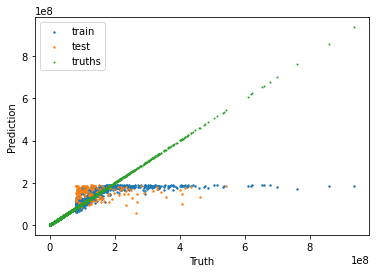

In [18]:
test_predictions = model.predict(test_data_in)
train_predictions = model.predict(train_data_in)
plt.scatter(train_data_out, train_predictions, label='train', s=2)
plt.scatter(test_data_out, test_predictions, label='test', s=2)
plt.scatter(real_data['gross'], real_data['gross'], label='truths', s=1)
plt.legend()
plt.xlabel('Truth')
plt.ylabel('Prediction')
plt.show()